In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid',font_scale=1.5)
pd.set_option('display.max.rows',None)
pd.set_option('display.max.columns',None)


In [2]:
from sklearn.svm import SVR
from sklearn.linear_model import BayesianRidge,LinearRegression,SGDRegressor,Lasso,ridge_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor,BaggingRegressor,GradientBoostingRegressor,RandomForestRegressor
from lightgbm import LGBMRegressor

In [3]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.metrics import mean_squared_error,r2_score
from imblearn.over_sampling import SMOTE

In [4]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s3e8/sample_submission.csv
/kaggle/input/playground-series-s3e8/train.csv
/kaggle/input/playground-series-s3e8/test.csv


In [5]:
test = pd.read_csv('/kaggle/input/playground-series-s3e8/test.csv',index_col=0)
train = pd.read_csv('/kaggle/input/playground-series-s3e8/train.csv',index_col=0)

In [6]:
train.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
id,,,,,,,,,,
0,1.52,Premium,F,VS2,62.2,58.0,7.27,7.33,4.55,13619
1,2.03,Very Good,J,SI2,62.0,58.0,8.06,8.12,5.05,13387
2,0.70,Ideal,G,VS1,61.2,57.0,5.69,5.73,3.50,2772
3,0.32,Ideal,G,VS1,61.6,56.0,4.38,4.41,2.71,666
4,1.70,Premium,G,VS2,62.6,59.0,7.65,7.61,4.77,14453


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193573 entries, 0 to 193572
Data columns (total 10 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   carat    193573 non-null  float64
 1   cut      193573 non-null  object 
 2   color    193573 non-null  object 
 3   clarity  193573 non-null  object 
 4   depth    193573 non-null  float64
 5   table    193573 non-null  float64
 6   x        193573 non-null  float64
 7   y        193573 non-null  float64
 8   z        193573 non-null  float64
 9   price    193573 non-null  int64  
dtypes: float64(6), int64(1), object(3)
memory usage: 16.2+ MB


In [8]:
train.isna().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
price      0
dtype: int64

This states that the dataset has no null or missing values. So we do not need to remove the missing values.

In [9]:
categorical=train.select_dtypes('object').columns
numerical=train.select_dtypes('number').columns
print('The categorical features are:',*categorical,sep=' ')
print('The numeric features are:', *numerical,sep=' ')

The categorical features are: cut color clarity
The numeric features are: carat depth table x y z price


In [10]:
print(f'The duplicates in training dataset is: {train.duplicated().sum()}')
print(f'The duplicates in test dataset is: {test.duplicated().sum()}')

The duplicates in training dataset is: 0
The duplicates in test dataset is: 535


In [11]:
print('The cardinality of the training dataset is: ')
print(train.select_dtypes('object').nunique())
print('-'*70)
print('The cardinality of test dataset is: ')
print(test.select_dtypes('object').nunique())


The cardinality of the training dataset is: 
cut        5
color      7
clarity    8
dtype: int64
----------------------------------------------------------------------
The cardinality of test dataset is: 
cut        5
color      7
clarity    8
dtype: int64


In [12]:
train.describe()

,carat,depth,table,x,y,z,price
count,193573.000000,193573.000000,193573.000000,193573.000000,193573.000000,193573.000000,193573.000000
mean,0.790688,61.820574,57.227675,5.715312,5.720094,3.534246,3969.155414
std,0.462688,1.081704,1.918844,1.109422,1.102333,0.688922,4034.374138
min,0.200000,52.100000,49.000000,0.000000,0.000000,0.000000,326.000000
25%,0.400000,61.300000,56.000000,4.700000,4.710000,2.900000,951.000000
50%,0.700000,61.900000,57.000000,5.700000,5.720000,3.530000,2401.000000
75%,1.030000,62.400000,58.000000,6.510000,6.510000,4.030000,5408.000000
max,3.500000,71.600000,79.000000,9.650000,10.010000,31.300000,18818.000000


In [13]:
train.describe(include='object')

,cut,color,clarity
count,193573,193573,193573
unique,5,7,8
top,Ideal,G,SI1
freq,92454,44391,53272


In [14]:
value_of_dataset=train.groupby(['carat','clarity']).agg({'price':'max'})
value_of_dataset.head(11)

price
carat clarity       
0.20  SI1        367
      VS1        399
      VS2        397
0.21  SI1        367
      SI2        386
      VS1        399
      VS2        536
      VVS2       778
0.22  SI2        367
      VS2        411
      VVS2       600

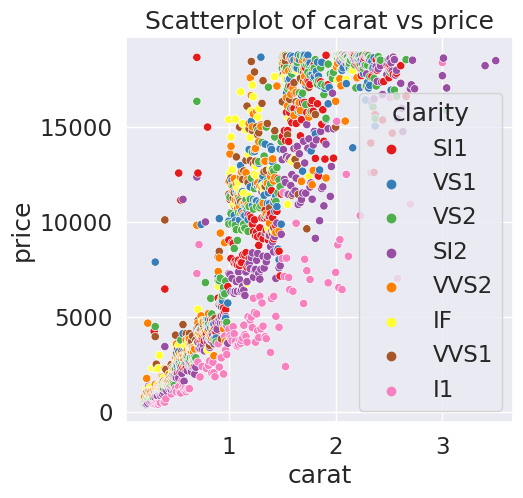

In [15]:
plt.figure(figsize=(5,5))
sns.scatterplot(data=value_of_dataset,x='carat',y='price',hue='clarity',palette='Set1')
plt.title('Scatterplot of carat vs price')
plt.show()

In [16]:
train.clarity.unique()

array(['VS2', 'SI2', 'VS1', 'SI1', 'IF', 'VVS2', 'VVS1', 'I1'],
      dtype=object)

<AxesSubplot:>

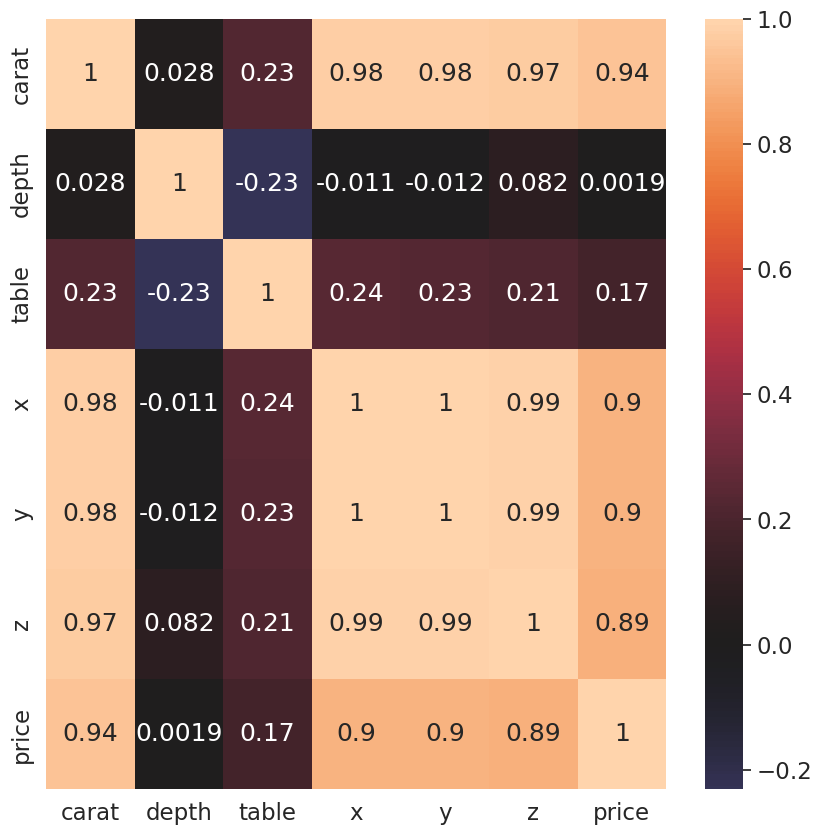

In [17]:
plt.figure(figsize=(10,10))
sns.heatmap(train.corr(),center=0,annot=True)

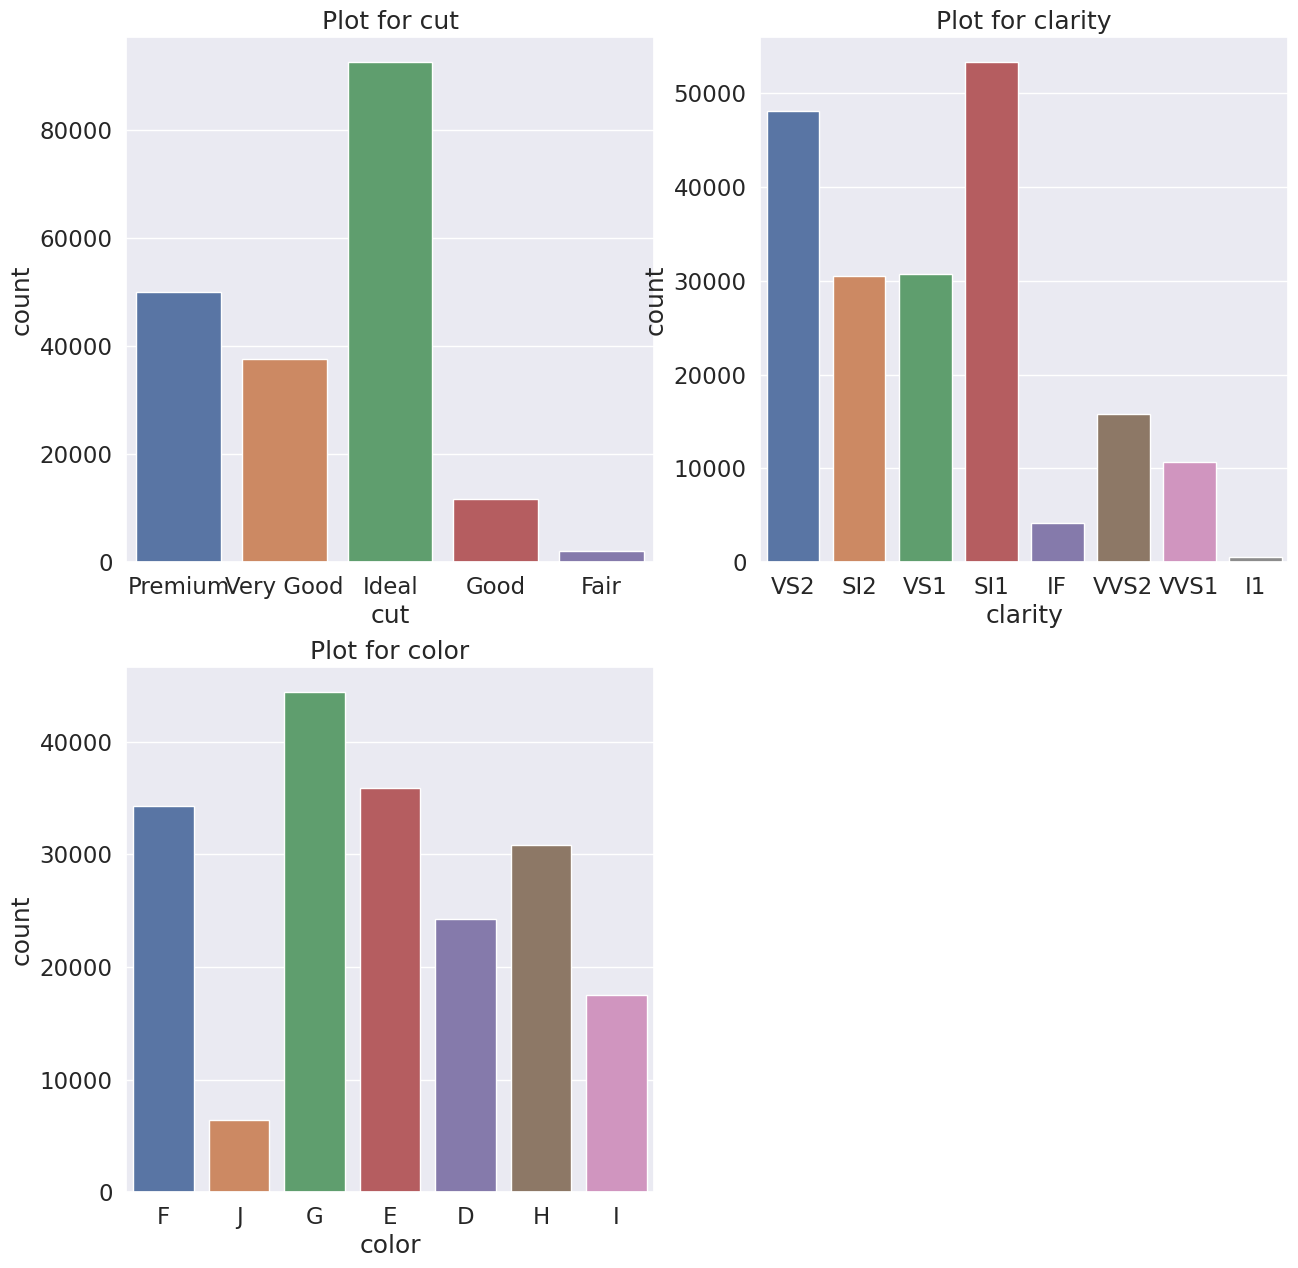

In [18]:
features=['cut','clarity','color']
plt.figure(figsize=(15,15))
for j,i in enumerate(features):
    plt.subplot(2,2,j+1)
    sns.countplot(data=train,x=i)
    plt.title(f'Plot for {i}')

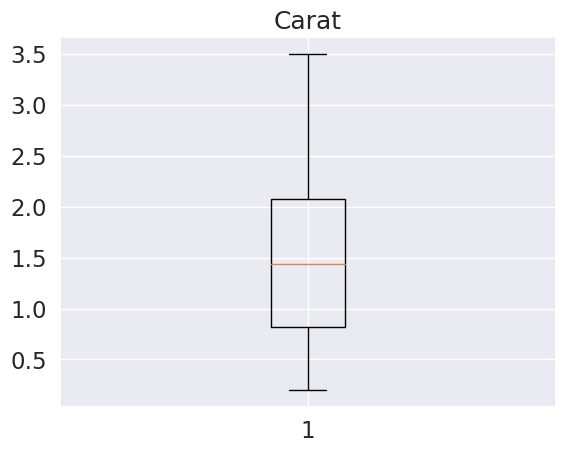

In [19]:
plt.boxplot(list(train.carat.value_counts().keys()))
plt.title('Carat')
plt.show()

<AxesSubplot:ylabel='Density'>

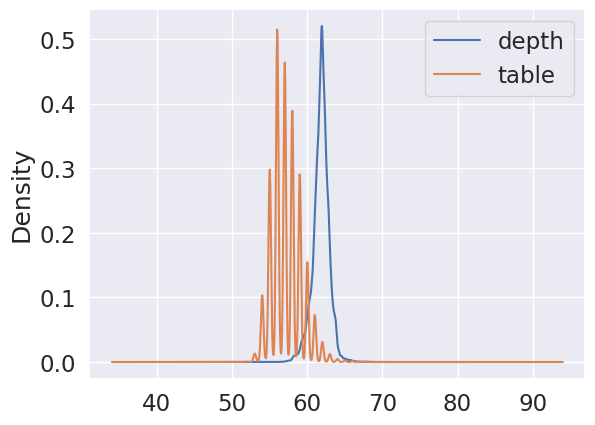

In [20]:
train[['depth','table']].plot.kde()

<AxesSubplot:ylabel='Density'>

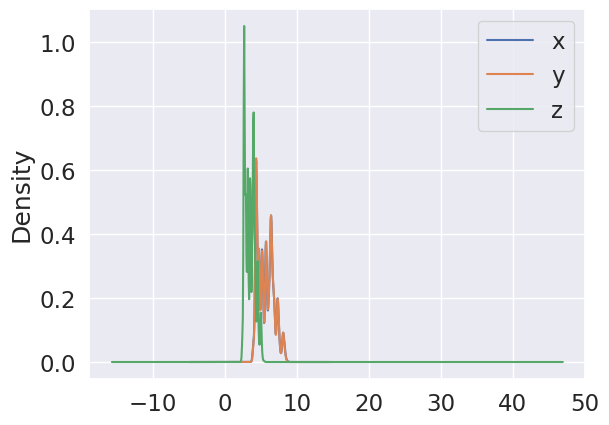

In [21]:
train[['x','y','z']].plot.kde()

In [22]:
def feature_engineering(df):
    data=df.copy()
    str_col=df.select_dtypes('object')
    data[pd.get_dummies(str_col).columns]=pd.get_dummies(str_col)
    label=LabelEncoder()
    for col in str_col:
        data[col]=label.fit_transform(data[col].astype('str'))
    return data

In [23]:
data_T=feature_engineering(train)

In [24]:
data_T.head()

,carat,cut,color,clarity,depth,table,x,y,z,price,cut_Fair,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_D,color_E,color_F,color_G,color_H,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.52,3,2,5,62.2,58.0,7.27,7.33,4.55,13619,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,2.03,4,6,3,62.0,58.0,8.06,8.12,5.05,13387,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
2,0.70,2,3,4,61.2,57.0,5.69,5.73,3.50,2772,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
3,0.32,2,3,4,61.6,56.0,4.38,4.41,2.71,666,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
4,1.70,3,3,5,62.6,59.0,7.65,7.61,4.77,14453,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0


In [25]:
X=data_T.drop(['price'],axis=1)
y=data_T[['price']]
X_train1,X_test1,y_train1,y_test1=train_test_split(X,y)

In [26]:
scalar=StandardScaler()
X=scalar.fit_transform(X)

In [27]:
X_train,X_test,y_train,y_test=train_test_split(X,y)

In [28]:
training_score=[]
test_score=[]
training_r2=[]
test_r2=[]
def model_prediction(model):
    model.fit(X_train,y_train)
    X_train_pred=model.predict(X_train)
    X_test_pred=model.predict(X_test)
    a=mean_squared_error(y_train,X_train_pred,squared=False)
    b=mean_squared_error(y_test,X_test_pred,squared=False)
    training_score.append(a)
    test_score.append(b)
    
    print(f'The training score of the {model} is: {a}')
    print(f'The test score of the {model} is: {b} ')


In [29]:
model_prediction(LinearRegression())

The training score of the LinearRegression() is: 947.3546478137165
The test score of the LinearRegression() is: 964.687662059126 


In [30]:
model_prediction(BayesianRidge())

The training score of the BayesianRidge() is: 947.3546470279122
The test score of the BayesianRidge() is: 964.6881459772605 


In [31]:
model_prediction(SGDRegressor())

The training score of the SGDRegressor() is: 950.3702106836395
The test score of the SGDRegressor() is: 968.201999402767 


In [32]:
model_prediction(Lasso(alpha=1.0,max_iter=100000))

The training score of the Lasso(max_iter=100000) is: 947.4254257216841
The test score of the Lasso(max_iter=100000) is: 962.2348716947862 


In [33]:
def model_prediction1(model):
    model.fit(X_train1,y_train1)
    X_train_pred1=model.predict(X_train1)
    X_test_pred1=model.predict(X_test1)
    a=mean_squared_error(y_train1,X_train_pred1,squared=False)
    b=mean_squared_error(y_test1,X_test_pred1,squared=False)
    training_score.append(a)
    test_score.append(b)
    print(f'The training score of the {model} is: {a}')
    print(f'The test score of the {model} is: {b} ')

In [34]:
model_prediction1(DecisionTreeRegressor())

The training score of the DecisionTreeRegressor() is: 14.464324692954829
The test score of the DecisionTreeRegressor() is: 826.4117439277005 


In [35]:
model_prediction1(RandomForestRegressor())

The training score of the RandomForestRegressor() is: 228.561427464374
The test score of the RandomForestRegressor() is: 609.5409352253677 


In [36]:
model_prediction1(LGBMRegressor())

The training score of the LGBMRegressor() is: 556.1612878945936
The test score of the LGBMRegressor() is: 576.3355683965243 


In [37]:
model_prediction(GradientBoostingRegressor())

The training score of the GradientBoostingRegressor() is: 621.2174307888633
The test score of the GradientBoostingRegressor() is: 635.0263791419561 


In [38]:
models = ["Linear Regression","BaysianRidge","SGD","Lasso","Decision Tree","Random Forest",
          "LGBM","Gradient Boost"]

In [39]:
len(training_score)
len(test_score)

8

In [40]:
df=pd.DataFrame({'Algorithms':models,'Training Score':training_score,'Test Score':test_score})

In [41]:
df

,Algorithms,Training Score,Test Score
0,Linear Regression,947.354648,964.687662
1,BaysianRidge,947.354647,964.688146
2,SGD,950.370211,968.201999
3,Lasso,947.425426,962.234872
4,Decision Tree,14.464325,826.411744
5,Random Forest,228.561427,609.540935
6,LGBM,556.161288,576.335568
7,Gradient Boost,621.217431,635.026379


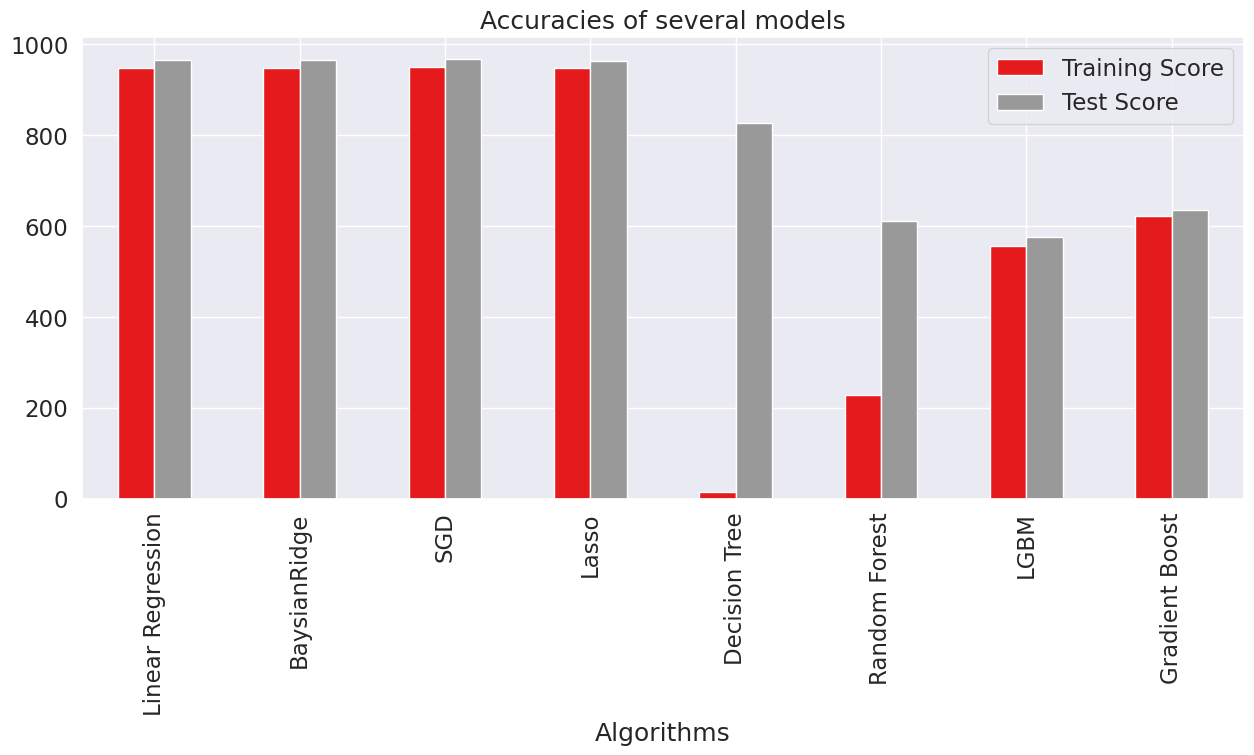

In [42]:
df.plot(x='Algorithms',y=['Training Score','Test Score'],figsize=(15,6),kind='bar',colormap='Set1',title='Accuracies of several models')
plt.show()

In [43]:
model1=LGBMRegressor().fit(X_train,y_train)


In [44]:
model1.score(X_train,y_train)

0.9811470300416525

In [45]:
model1.score(X_test,y_test)

0.9790818545776051

In [46]:
prepare_test_df = feature_engineering(test.copy())
prepare_test_df = scalar.fit_transform(prepare_test_df)

In [47]:
sample = pd.read_csv('/kaggle/input/playground-series-s3e8/sample_submission.csv')
sample.price = model1.predict(prepare_test_df)

In [48]:
sample.to_csv('submission.csv',index=False)